In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
plt.style.use(os.path.abspath("../paper_plots/paper.mplstyle"))

## `icemodel.par`

Most of the values in this are taken from https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687

In [2]:
alpha = 0.9 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
alphae = 0.03 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
kappa = 1.08 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
kappae = 0.01 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
air = 6954 # m^-1 https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
aire = 973 # m^-1 https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
lambda0 = 6618 # nm https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
lambda0e = 71 # nm https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687
D = 71 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687 Relation from https://arxiv.org/pdf/1301.5361.pdf needed
De = 12 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687 Relation from https://arxiv.org/pdf/1301.5361.pdf needed
E = 2.6 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687 Relation from https://arxiv.org/pdf/1301.5361.pdf needed
Ee = 0.6 # https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2005JD006687 Relation from https://arxiv.org/pdf/1301.5361.pdf needed
v = [alpha, kappa, air, lambda0, D, E]
e = [alphae, kappae, aire, lambda0e, De, Ee]

In [5]:
with open("../resources/PPC_tables/my_south_pole/icemodel.par", "w") as f:
    for idx, (x, y) in enumerate(zip(v, e)):
        l = f"{x} {y}"
        if idx < len(v)-1:
            l += "\n"
        f.write(l)

## `icemodel.dat`

In [7]:
x = np.genfromtxt("../resources/PPC_tables/south_pole//icemodel.dat")

### Scattering

Based on equations from https://arxiv.org/ftp/arxiv/papers/1911/1911.02016.pdf the total scattering is given by $b_{e}(\lambda, d | \kappa) =  b_{e}(400\, nm, d) \left(\frac{\lambda}{400\, nm}\right)^{\kappa}$. We take the values of b_{e} from https://arxiv.org/ftp/arxiv/papers/1911/1911.02016.pdf

In [30]:
from scipy.interpolate import interp1d

# Load in the digitized data
scatter = np.genfromtxt("/Users/jlazar/Downloads/scatter_coef.csv", delimiter=",")
scatter_interp = interp1d(scatter[:, 0], scatter[:, 1])
absorb = np.genfromtxt("/Users/jlazar/Downloads/absorb_coef.csv", delimiter=",")
absorb_interp = interp1d(absorb[:, 0], absorb[:, 1])


min_depth = max(scatter[:, 0].min(), absorb[:, 0].min())
max_depth = min(scatter[:, 0].max(), absorb[:, 0].max())
d_depth = 10.0 # m
current_depth = min_depth
depths = []
while current_depth < max_depth:
    depths.append(current_depth)
    current_depth += d_depth
depths = np.array(depths)

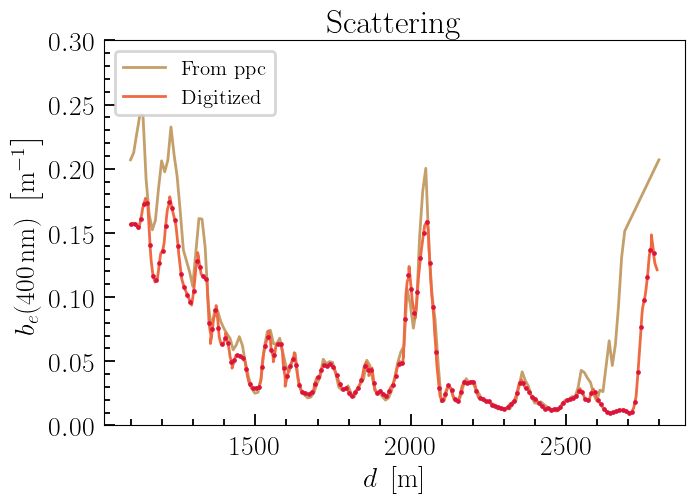

In [31]:
plt.plot(x[:, 0], x[:, 1], label="From ppc")
plt.plot(scatter[:, 0], scatter[:, 1], label="Digitized")
plt.scatter(depths, scatter_interp(depths), s=2, color="crimson", zorder=10)
plt.title("Scattering")
plt.ylabel(r"$b_{e}(400\,{\rm{nm}})~\left[\rm{m}^{-1}\right]$")
plt.xlabel(r"$d~\left[\rm{m}\right]$")
plt.legend(fontsize=15, loc=2)
plt.ylim(0, 0.3)
plt.show()

### Absorption

As per https://arxiv.org/ftp/arxiv/papers/1911/1911.02016.pdf the total scattering coefficient is:

$$a(\lambda,\,d\,| A_{U}, B_{U}, A_{IR}, \lambda_{0}) = a_{dust}(400\, nm, d)\left(\frac{\lambda}{400\, nm}\right)^{k} + A_{U}e^{B_{U}\lambda} + A_{IR}e^{-\lambda_{0}/\lambda}(1+0.01*\delta t)$$

As per, https://arxiv.org/pdf/1301.5361.pdf which this equation is reproduced from, $\delta t(d)= T(d) - T(1730\,m)$, and the temperature is parameterized as $T(d) = 221.5 - 4.5319\times10^{-4} d + 5.882\times10^{-6} d^{2}$

Let's calculate the temperature first.

In [32]:
def temp(depth):
    """According to https://arxiv.org/pdf/1301.5361.pdf"""
    t = 221.5 - 0.00045319 * depth + 5.882e-6 * depth**2
    return t

def dt(depth):
    """According to https://arxiv.org/ftp/arxiv/papers/1911/1911.02016.pdf"""
    return temp(depth) - temp(1730)

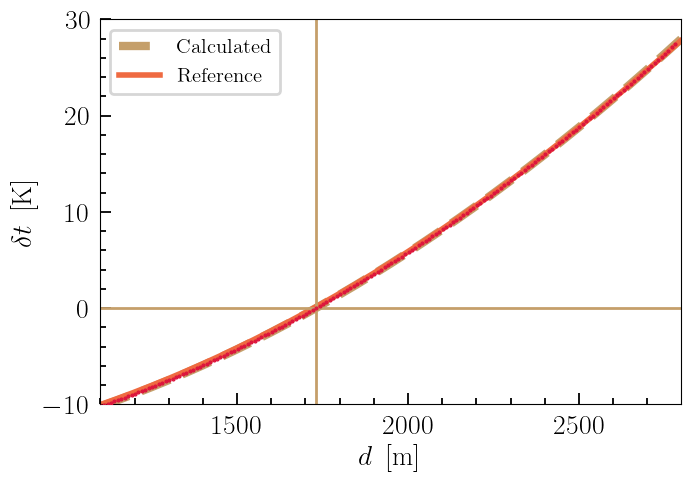

In [39]:
plt.plot(x[:, 0], dt(x[:, 0]), ls="--", lw=6, label="Calculated")
plt.plot(x[:, 0], x[:, 3], label="Reference", lw=4)
plt.scatter(depths, dt(depths), s=1, zorder=10, c="crimson")
plt.axvline(1730)
plt.axhline(0)
plt.legend(fontsize=15)
plt.xlabel(r"$d~\left[\rm{m}\right]$")
plt.ylabel(r"$\delta t~\left[\rm{K}\right]$")
plt.xlim(x[0, 0], x[-1, 0])
plt.ylim(-10, 30)
plt.show()

Here's whre things get interesting. It does not look like `PPC` uses the UV cutoff in the code. I imagine that this is because the Cherenkov spectrumat those wavelngths is negligible. Instead the total absorption is [calculated](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L593) as 

$$a(d) = (D \times ba(d) + E) \times wva^{-k} + A e^{-B/wva}\left[1+0.01*td(d)\right]$$

Under the substitutions $D\times ba(d) + E \rightarrow a_{dust}(400\, nm, d)$, $wva\rightarrow \frac{\lambda}{400\, nm}$

In [51]:
aux = ((absorb_interp(depths) - air * np.exp(-lambda0)*(1+0.01*dt(depths))) / (400**-kappa) - E) / D

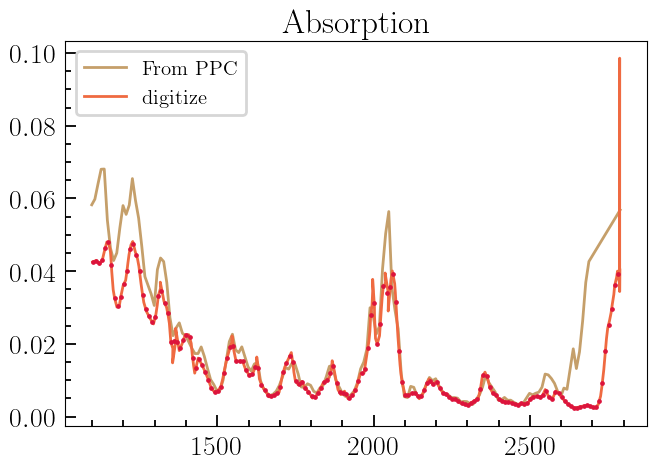

In [52]:
plt.plot(x[:-1, 0], (D*x[:-1, 2]+E)*400**-kappa + air * np.exp(-lambda0)*(1+0.01*dt(x[:-1, 2])), label="From PPC")
plt.scatter(depths, (D*aux+E)*400**-kappa + air * np.exp(-lambda0)*(1+0.01*dt(depths)), color="crimson", s=2, zorder=10)
plt.plot(absorb[:, 0], absorb[:, 1], label="digitize")
plt.title("Absorption")
plt.legend(fontsize=15)
plt.show()

In [57]:
with open("../resources/PPC_tables/my_south_pole/icemodel.dat", "w") as f:
    for idx, (w, x, y, z) in enumerate(zip(depths, scatter_interp(depths), aux, dt(depths))):
        l = f"{w} {x} {y} {z}\n"
        f.write(l)
    f.write(f"{w+d_depth} {x} 1000 {dt(w+d_depth)}")

## `cfg.txt`

This table gets read in [here](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L286). It requires at least four paramters. These control:
- The OM oversizig relative to 16.51 cm
- The overall efficiency correction
- The relative contribution of the scattering models. Following the convention from [earlier in the code](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L179) 0=HG and 1=SAM
- The expected value of the scattering angle, g=$\left<\cos\theta_{s}\right>$

In [58]:
om_oversize = 1.0
om_efficiency = 1.0
f = 0.45 # https://arxiv.org/pdf/1301.5361.pdf
g = 0.9 # https://arxiv.org/pdf/1301.5361.pdf

with open("../resources/PPC_tables/my_south_pole/cfg.txt", "w") as f:
    f.write(f"{om_oversize} # OM oversizing relative to 16.51 cm\n")
    f.write(f"{om_efficiency} # OM efficiency scaling\n")
    f.write(f"{f} # fs from https://arxiv.org/pdf/1301.5361.pdf\n")
    f.write(f"{g} # <costheta> from https://arxiv.org/pdf/1301.5361.pdf")

We will stop here, but for completeness, it looks like there can be up to 8 more lines, which control, in order:
- The angle in degrees of the anisotropy
- Log of the first ice anisotropy parameter
- Log of the second ice anisotropy parameter
- The hole ice radius relative to the OM radius of 16 cm
- Numbers relating to the effective scattering length in the ice. Look into this more carefully if you are going to venture into this. [Relevant](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L304) [lines](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L184)
- Numbers relating to the effective absorption length in the ice. Look into this more carefully if you are going to venture into this. [Relevant](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L304) [lines](https://github.com/Harvard-Neutrino/prometheus/blob/main/resources/PPC_executables/PPC_CUDA/ini.cxx#L184)
- The hole ice relative scattering contribution
- The hole ice expectation of the scattering angle

## wv.dat

In [60]:
from scipy.integrate import quad
from scipy.interpolate import interp1d

In [61]:
ll = np.linspace(265, 670)
om_acceptance = np.genfromtxt("/Users/jlazar/Downloads/cherenkov_convolv_om.csv", delimiter=",")
interp = interp1d(om_acceptance[:, 0], om_acceptance[:, 1], )
x = np.array([quad(interp, ll[0], l)[0] for l in ll]) / quad(interp, ll[0], ll[-1])[0]
wv = np.genfromtxt("../resources/PPC_tables/south_pole//wv.dat")

/var/folders/4q/ncd7kk_j2t9_syxd3gmst9mc0000gn/T/ipykernel_46939/728166754.py:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  x = np.array([quad(interp, ll[0], l)[0] for l in ll]) / quad(interp, ll[0], ll[-1])[0]


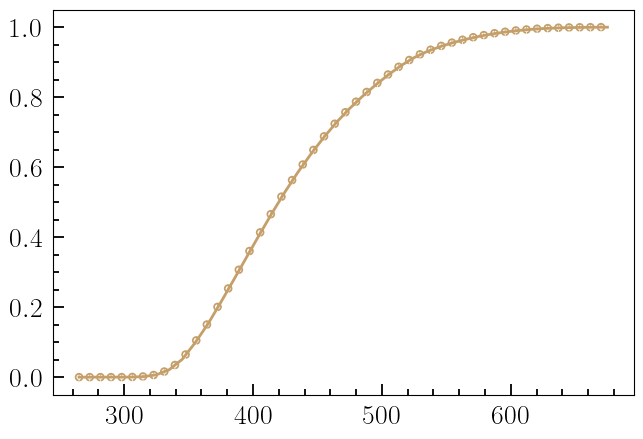

In [63]:
plt.scatter(ll, x, ls="--", lw=5, s=1.5)
plt.plot(wv[:, 1], wv[:, 0])
plt.show()

In [65]:
wv[:,0]

array([0.0000000e+00, 8.5940000e-05, 1.6545000e-04, 2.3922000e-04,
       2.6260000e-04, 1.5912500e-03, 6.7463500e-03, 2.1484030e-02,
       5.0869360e-02, 9.7984140e-02, 1.5199135e-01, 2.1392158e-01,
       2.7810481e-01, 3.4290594e-01, 4.0740505e-01, 4.7048256e-01,
       5.3060305e-01, 5.8642167e-01, 6.3801181e-01, 6.8561840e-01,
       7.2907412e-01, 7.6787692e-01, 8.0281049e-01, 8.3465433e-01,
       8.6393911e-01, 8.9059949e-01, 9.1308850e-01, 9.3046755e-01,
       9.4420183e-01, 9.5555651e-01, 9.6524596e-01, 9.7344983e-01,
       9.8031902e-01, 9.8584527e-01, 9.9023700e-01, 9.9355119e-01,
       9.9604905e-01, 9.9769795e-01, 9.9877149e-01, 9.9939597e-01,
       9.9976730e-01, 1.0000000e+00])

In [66]:
with open("../resources/PPC_tables/my_south_pole/wv.dat", "w") as f:
    for idx, (wv, cdf) in enumerate(zip(ll, x)):
        l = f"{cdf} {cdf}"
        if idx < len(ll):
            l += "\n"
        f.write(l)

## `tilt.par`

## `tilt.dat`

## DOM positions

In [15]:
a = np.array([-2450 + 17 * x for x in range(0,60)])
b = np.linspace(-2450, -1450, 60)
c = np.append(np.linspace(-2450, -2100, 50) , np.linspace(-1850, -1760, 10))

In [16]:
string_yx = np.genfromtxt("/Users/jlazar/Downloads/string_positions.csv", delimiter=",")

In [17]:
my_oms_a = np.empty((86, 60, 3))
my_oms_b = np.empty((86, 60, 3))
for i in range(86):
    for j in range(60):
        if i < 78:
            my_oms_a[i, j, 2] = a[59 - j]
            my_oms_b[i, j, 2] = b[59 - j]
        else:
            my_oms_a[i, j, 2] = c[59 - j]
            my_oms_b[i, j, 2] = c[59 - j]
        my_oms_a[i, j, :2] = string_yx[i]
        my_oms_b[i, j, :2] = string_yx[i]
        

In [21]:
their_om = np.empty((86, 60, 3))
with open("/Users/jlazar/dat/All/geo-f2k") as f:
    for line in f:
        line = line.strip("\n")
        splitline = [float(x) for x in line.split("\t")[2:]]
        if splitline[-1]>60:
            continue
        i = int(splitline[3] - 1)
        j = int(splitline[4] - 1)
        their_om[i, j, :] = splitline[:3]

In [22]:
ha, bins = np.histogram(np.linalg.norm(their_om - my_oms_a, axis=-1).flatten(), bins=50)
hb, bins = np.histogram(np.linalg.norm(their_om - my_oms_b, axis=-1).flatten(), bins=50)

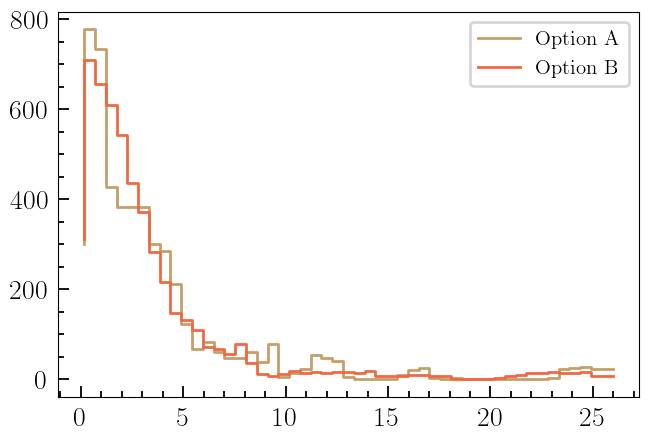

In [23]:
plt.step(bins[:-1], ha, where="pre", label="Option A")
plt.step(bins[:-1], hb, where="pre", label="Option B")
plt.legend(loc=1, fontsize=15)
plt.show()

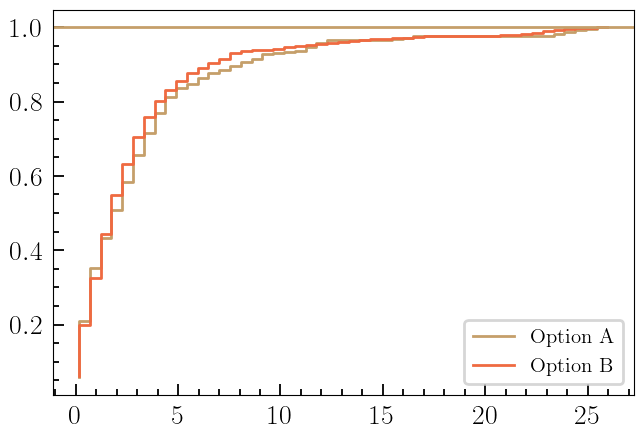

In [162]:
plt.step(bins[:-1], np.cumsum(ha) / 5160, where="pre", label="Option A")
plt.step(bins[:-1], np.cumsum(hb) / 5160, where="pre", label="Option B")
plt.legend(loc=4, fontsize=15)
plt.axhline(1)
plt.show()

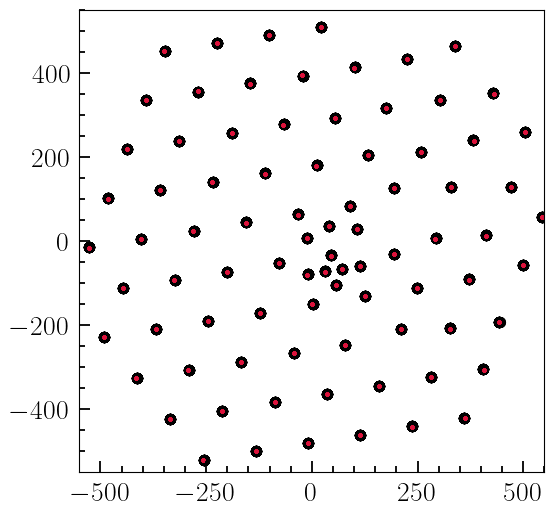

In [28]:
fig, ax = plt.subplots(figsize=(6,6))

plt.scatter(their_om[:, :, 0].flatten(), their_om[:, :, 1].flatten(), color="k")
plt.scatter(my_oms_a[:, :, 0].flatten(), my_oms_a[:, :, 1].flatten(), color="crimson", s=1)
plt.xlim(-550, 550)
plt.ylim(-550, 550)
plt.show()